In [23]:
import numpy as np
from torch import Tensor
from torch.nn import Linear
from torch.nn import Tanh
from torch.nn import ReLU
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_
#from torchinfo import summary

In [53]:
import gym
env = gym.make('BipedalWalker-v3')
print("Actions:", env.action_space)
print("Observations:", env.observation_space)

Actions: Box([-1. -1. -1. -1.], [1. 1. 1. 1.], (4,), float32)
Observations: Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf], (24,), float32)


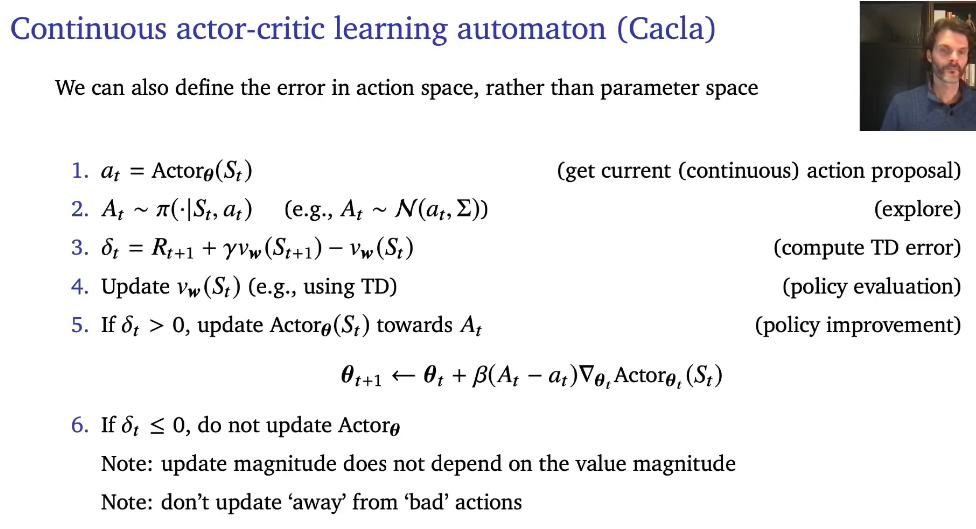

In [34]:
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        # noise = OUActionNoise()
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt +\
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [35]:
class Actor(Module):
    def __init__(self, lr, n_inputs, hidden1_width, hidden2_width, n_outputs):
        super(Actor, self).__init__()
        self.hidden1 = Linear(n_inputs, hidden1_width)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = ReLU()

        self.hidden2 = Linear(hidden1_width, hidden2_width)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = ReLU()

        self.hidden3 = Linear(hidden2_width, n_outputs)
        self.act3 = Tanh() # used bc action space is [-1,1]

        self.optimizer = Adam(self.parameters(), lr=lr)

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)

        X = self.hidden2(X)
        X = self.act2(X)

        X = self.hidden3(X)
        X = self.act3(X)

        return X

In [36]:
class Critic(Module):
    def __init__(self, lr, n_inputs, hidden1_width, hidden2_width, n_outputs=1):
        super(Critic, self).__init__()
        self.hidden1 = Linear(n_inputs, hidden1_width)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = ReLU()

        self.hidden2 = Linear(hidden1_width, hidden2_width)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = ReLU()

        self.hidden3 = Linear(hidden2_width, n_outputs)
        self.act3 = Tanh()

        self.optimizer = Adam(self.parameters(), lr=lr)

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)

        X = self.hidden2(X)
        X = self.act2(X)

        X = self.hidden3(X)
        X = self.act3(X)

        return X

In [111]:
class Agent:
    def __init__(self, env, n_actions, critic_lr, actor_lr, gamma, epochs):
        self.actor = Actor(lr=actor_lr, n_inputs=24, hidden1_width=256, hidden2_width=256, n_outputs=4)
        self.critic = Critic(lr=critic_lr, n_inputs=24, hidden1_width=256, hidden2_width=256, n_outputs=1)

        self.env=env

        self.gamma = gamma
        self.epochs = epochs

        self.noise = OUActionNoise(mu=np.zeros(n_actions))
        print(self.noise)

    def train(self, alpha, beta):
        for i in range(self.epochs):
            sum_of_rewards = 0
            done = False
            state = self.env.reset()


            while not done:
                state = Tensor(state)
                print("State:", state)
                action = self.actor.forward(state)
                print("Action:", action)

                print("Noise", Tensor(self.noise()))

                noisy_action = action + Tensor(self.noise()) # don't think this is right
                print("Noisy action", noisy_action)
                new_state, reward, done, _ = env.step(noisy_action.detach().numpy())
                print("New state:", new_state)
                new_state = Tensor(new_state)
                print("New state:", new_state)

                yhat = self.critic.forward(state)
                y = reward + self.gamma * self.critic.forward(new_state)
                td_error = y - yhat

                critic_loss = alpha * td_error
                #self.critic.parameters() += alpha * td_error
                self.critic.optimizer.zero_grad()
                critic_loss.backward()
                self.critic.optimizer.step()

                if td_error > 0:
                    # update actor
                    # the idea is to move the output of actor network towards the noisy action
                    #self.actor.parameters() += beta * (action - )
                    actor_loss = 1/2 * (noisy_action - action)

                    self.actor.optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor.optimizer.step()

                state = new_state
            print("Epoch: ", i ," Rewards: ", sum_of_rewards)

In [112]:
actor = Agent(env=env, n_actions=4, critic_lr=0.03, actor_lr=0.03, gamma=0.9, epochs=100)
actor.train(alpha=0.1, beta=0.1)

State: tensor([ 2.7458e-03,  1.0371e-05, -1.3524e-03, -1.6000e-02,  9.2483e-02,
         3.1394e-03,  8.5980e-01, -1.0934e-03,  1.0000e+00,  3.2801e-02,
         3.1393e-03,  8.5354e-01, -2.1361e-03,  1.0000e+00,  4.4081e-01,
         4.4582e-01,  4.6142e-01,  4.8955e-01,  5.3410e-01,  6.0246e-01,
         7.0915e-01,  8.8593e-01,  1.0000e+00,  1.0000e+00])
Action: tensor([-0.1256, -0.0857,  0.0397,  0.0314], grad_fn=<TanhBackward0>)
Noise tensor([ 0.0154, -0.0034,  0.0040,  0.0291])
Noisy action tensor([-0.1302, -0.1074,  0.0361,  0.0597], grad_fn=<AddBackward0>)
New state: [-0.00359921  0.00317318 -0.00433293 -0.00170723  0.43504116  0.15116705
  0.11271471 -0.22523056  1.          0.33657658 -0.01377926  0.11514342
 -0.00403496  1.          0.44961077  0.45471677  0.4706308   0.4993195
  0.5447612   0.61448354  0.72330046  0.9036112   1.          1.        ]
New state: tensor([-0.0036,  0.0032, -0.0043, -0.0017,  0.4350,  0.1512,  0.1127, -0.2252,
         1.0000,  0.3366, -0.0138, 

RuntimeError: grad can be implicitly created only for scalar outputs